In [1]:
%load_ext rpy2.ipython

In [2]:
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timezone, timedelta
import seaborn as sns
import pingouin as pg
import scipy.stats as stats
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

In [3]:
# reformat axis ticks to only show hour/min
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
import matplotlib.pyplot as plt
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [5]:
label_fontsize = 16
title_fontsize = 18

In [6]:
pd.set_option('mode.chained_assignment', None)

In [7]:
%%R
#install.packages("MuMIn", repos='http://cran.us.r-project.org')

NULL


In [8]:
%%R
rm(list = ls())  #remove elements from current workspace
library("plyr")
library("emmeans")
library("reshape2")
library("multcomp")
library("MuMIn")

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: TH.data

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘TH.data’


R[write to console]: The following object is masked from ‘package:MASS’:

    geyser




In [9]:
basefolder = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/"

In [10]:
inputfolderpath = basefolder + "data/beh_data/movement/"

In [11]:
basefiles = [   "02_27072018_SponSleep_LFP", "03_14092018_SponSleep_LFP",
                "04_17092018_SponSleep_LFP", "06_30102018_SponSleep_LFP",
                "07_01112018_SponSleep_LFP", "08_03112018_SponSleep_LFP", 
                "09_13112018_SponSleep_LFP", 
                "12_28112018_SponSleep_LFP",
                "14_11122018_SponSleep_LFP", "15_13122018_SponSleep_LFP",
                "16_18122018_SponSleep_LFP",
                "17_10012019_SponSleep_LFP", 
                "18_17012019_SponSleep_LFP", "19_22012019_SponSleep_LFP", 
                "21_20022019_SponSleep_LFP", "23_13032019_SponSleep_LFP"]

In [12]:
#Ignored flies..
ignoredfiles = [
                "01_11072018_SponSleep_LFP" #-- No calib, 
                "05_19092018_SponSleep_LFP",#-- Noisy calib
                "10_21112018_SponSleep_LFP",#-- Very little sleep trials
                "11_22112018_SponSleep_LFP",#-- Very Noisy calib
                "13_29112018_SponSleep_LFP",#-- Inactive after 4 hours
                "20_07022019_SponSleep_LFP",#-- No sleep data
                "22_06032019_SponSleep_LFP",#-- Noisy calib
]

In [13]:
print('Total flies:  ',len(basefiles) + len(ignoredfiles))
print('Used flies:   ',len(basefiles))
print('Ignored flies:',len(ignoredfiles))

Total flies:   22
Used flies:    16
Ignored flies: 6


In [14]:
def activityperzeit(datasetpath):
    
    df_epochs = pd.read_csv(datasetpath, index_col = 0)
    df_epochs['Start_time'] = pd.to_datetime(df_epochs['Start_time'], format='%Y-%m-%d %H:%M:%S')
    df_epochs['End_time'] = pd.to_datetime(df_epochs['End_time'], format='%Y-%m-%d %H:%M:%S')
    df_epochs['Duration'] = df_epochs['End_time'] - df_epochs['Start_time']
    df_epochs = df_epochs.rename(columns={'Type': 'type', 'Start_time': 'start', 'End_time': 'end', 'Duration': 'duration'})
    #df_epochs['mins'] = (df_epochs['duration'].dt.seconds//60)%60
    df_epochs['mins'] = df_epochs['duration'].dt.seconds/60
    df_epochs['zeit'] = None
    df_epochs.loc[(df_epochs['start'].dt.hour>=8) & (df_epochs['end'].dt.hour<20),'zeit'] = '08:to:20'
    df_epochs.loc[(df_epochs['start'].dt.hour>=20) | (df_epochs['end'].dt.hour<8),'zeit'] = '20:to:08'
    
    
    df_epochs.drop(['start', 'end', 'duration'], axis=1, inplace=True)
      
    return df_epochs

In [15]:
df_sleepperflyall = pd.DataFrame(columns = ['flyname','type', 'mins', 'zeit'])
df_awakeperflyall = pd.DataFrame(columns = ['flyname','type', 'mins', 'zeit'])
for f, basefilename in enumerate(basefiles):  # Loop across each fly
    inputfilepath = inputfolderpath + '16hrs_awakesleep' + '/'+ basefilename[3:] + "_merged_epochs.csv"
    print(basefilename[3:])
    print(inputfilepath)
    df_activityperfly =  activityperzeit(inputfilepath)
    df_activityperfly['flyname'] = basefilename[3:]
    
    df_sleepperfly = df_activityperfly[df_activityperfly.type == 'sleep']
    df_awakeperfly = df_activityperfly[df_activityperfly.type == 'awake']
        
    df_sleepperflyall = df_sleepperflyall.append(df_sleepperfly, ignore_index = True)
    df_sleepperflyall = df_sleepperflyall.dropna()
    df_sleepperflyall['mins'] = df_sleepperflyall['mins'].astype(float)
    
    df_awakeperflyall = df_awakeperflyall.append(df_awakeperfly, ignore_index = True)
    df_awakeperflyall = df_awakeperflyall.dropna()
    df_awakeperflyall['mins'] = df_awakeperflyall['mins'].astype(float)

27072018_SponSleep_LFP
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/beh_data/movement/16hrs_awakesleep/27072018_SponSleep_LFP_merged_epochs.csv
14092018_SponSleep_LFP
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/beh_data/movement/16hrs_awakesleep/14092018_SponSleep_LFP_merged_epochs.csv
17092018_SponSleep_LFP
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/beh_data/movement/16hrs_awakesleep/17092018_SponSleep_LFP_merged_epochs.csv
30102018_SponSleep_LFP
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/beh_data/movement/16hrs_awakesleep/30102018_SponSleep_LFP_merged_epochs.csv
01112018_SponSleep_LFP
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/beh_data/movement/16hrs_aw

In [16]:
df_sleepperflyall.head()

,flyname,type,mins,zeit
0,27072018_SponSleep_LFP,sleep,25.250000,08:to:20
1,27072018_SponSleep_LFP,sleep,19.100000,08:to:20
2,27072018_SponSleep_LFP,sleep,11.200000,08:to:20
3,27072018_SponSleep_LFP,sleep,27.383333,08:to:20
4,27072018_SponSleep_LFP,sleep,5.850000,08:to:20


In [17]:
df_awakeperflyall.head()

,flyname,type,mins,zeit
0,27072018_SponSleep_LFP,awake,37.733333,08:to:20
1,27072018_SponSleep_LFP,awake,6.033333,08:to:20
2,27072018_SponSleep_LFP,awake,8.416667,08:to:20
3,27072018_SponSleep_LFP,awake,4.100000,08:to:20
4,27072018_SponSleep_LFP,awake,7.566667,08:to:20


In [18]:
df_sleepperflyall['zeit'].unique()

array(['08:to:20', '20:to:08'], dtype=object)

In [19]:
df_sleepperflyall['type'].unique()

array(['sleep'], dtype=object)

In [20]:
missing_df = []
# iterate over all flyname and zeits to check for missing data in particular times
for flyname in df_sleepperflyall['flyname'].unique():
    for zeit in df_sleepperflyall['zeit'].unique():
        # check if the current flyname/zeit combination is already present
        if not ((df_sleepperflyall['flyname'] == flyname) & (df_sleepperflyall['zeit'] == zeit)).any():
            # if not, add a row with the missing zeit and NaN for mins
            new_row = {'flyname': flyname, 'type':'sleep','zeit': zeit, 'mins': np.nan}
            missing_df.append(new_row)

In [21]:
missing_df = pd.DataFrame(missing_df)
missing_df

,flyname,type,zeit,mins
0,13112018_SponSleep_LFP,sleep,08:to:20,NaN
1,18122018_SponSleep_LFP,sleep,20:to:08,NaN


In [22]:
df_sleepperflyall = pd.concat([df_sleepperflyall,missing_df])

In [23]:
df_sleepperflyall = df_sleepperflyall.sort_values(by='flyname')

In [24]:
df_sleepperflyall

,flyname,type,mins,zeit
91,01112018_SponSleep_LFP,sleep,69.366667,08:to:20
88,01112018_SponSleep_LFP,sleep,6.000000,08:to:20
87,01112018_SponSleep_LFP,sleep,7.633333,20:to:08
86,01112018_SponSleep_LFP,sleep,20.533333,20:to:08
85,01112018_SponSleep_LFP,sleep,5.700000,20:to:08
...,...,...,...,...
57,30102018_SponSleep_LFP,sleep,13.416667,20:to:08
58,30102018_SponSleep_LFP,sleep,11.583333,20:to:08
59,30102018_SponSleep_LFP,sleep,18.200000,20:to:08
70,30102018_SponSleep_LFP,sleep,6.083333,08:to:20


In [25]:
print('unique activities :', df_sleepperflyall.type.unique())
print('unique zeit :', df_sleepperflyall.zeit.unique())

unique activities : ['sleep']
unique zeit : ['08:to:20' '20:to:08']


In [26]:
print('unique activities :', df_awakeperflyall.type.unique())
print('unique zeit :', df_awakeperflyall.zeit.unique())

unique activities : ['awake']
unique zeit : ['08:to:20' '20:to:08']


In [27]:
df_sleepperflyall['zeit'].value_counts()

08:to:20    114
20:to:08    107
Name: zeit, dtype: int64

In [28]:
%R -i df_sleepperflyall

In [29]:
%%R
head(df_sleepperflyall)

                 flyname  type      mins     zeit
1 01112018_SponSleep_LFP sleep 69.366667 08:to:20
2 01112018_SponSleep_LFP sleep  6.000000 08:to:20
3 01112018_SponSleep_LFP sleep  7.633333 20:to:08
4 01112018_SponSleep_LFP sleep 20.533333 20:to:08
5 01112018_SponSleep_LFP sleep  5.700000 20:to:08
6 01112018_SponSleep_LFP sleep  7.283333 20:to:08


In [30]:
%%R
unique(df_sleepperflyall$zeit)

[1] "08:to:20" "20:to:08"


In [31]:
%%R
unique(df_sleepperflyall$type)

[1] "sleep"


In [32]:
%%R
packageVersion("lme4")

[1] ‘1.1.21’


In [33]:
%%R
# Multilevel model with missing values ~ Hierarchical model
# First compare and choose the best model..

library(lmerTest)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [34]:
%%R
head(df_sleepperflyall)

                 flyname  type      mins     zeit
1 01112018_SponSleep_LFP sleep 69.366667 08:to:20
2 01112018_SponSleep_LFP sleep  6.000000 08:to:20
3 01112018_SponSleep_LFP sleep  7.633333 20:to:08
4 01112018_SponSleep_LFP sleep 20.533333 20:to:08
5 01112018_SponSleep_LFP sleep  5.700000 20:to:08
6 01112018_SponSleep_LFP sleep  7.283333 20:to:08


In [35]:
%%R
model.null = lmer(mins ~ 1 + (1|flyname), data=df_sleepperflyall,
                  REML=FALSE)

model.zeit = lmer(mins ~ zeit + (1|flyname), data=df_sleepperflyall,
                  REML=FALSE)

R[write to console]: boundary (singular) fit: see ?isSingular



In [36]:
%%R
#compare the null model, with the zeit model..
print(anova(model.null,model.zeit))

Data: df_sleepperflyall
Models:
model.null: mins ~ 1 + (1 | flyname)
model.zeit: mins ~ zeit + (1 | flyname)
           Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)   
model.null  3 2287.9 2298.1 -1141.0   2281.9                            
model.zeit  4 2281.9 2295.4 -1136.9   2273.9 8.0327      1   0.004594 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [37]:
%%R
#the above analysis show that the zeit model is the most likely model..
#let's analyse the same..
print(anova(model.zeit))

Type III Analysis of Variance Table with Satterthwaite's method
     Sum Sq Mean Sq NumDF  DenDF F value   Pr(>F)   
zeit  18691   18691     1 168.42  10.194 0.001682 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [38]:
%%R
library("MuMIn")
r.squaredGLMM(model.zeit)

            R2m        R2c
[1,] 0.04673934 0.08348339


In [39]:
%%R
#the above table shows that there is a main effect of zeit(day, night); let's find out more..

NULL


In [40]:
%%R
library("multcomp")
# Step 5: Post Hoc comparisions 
df_sleepperflyall$typezeit <- interaction(df_sleepperflyall$type, df_sleepperflyall$zeit)

model = lmer(mins ~ typezeit + (1|flyname), data=df_sleepperflyall,
             REML=FALSE)

print(summary(glht(model, mcp(typezeit="Tukey"))))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = mins ~ typezeit + (1 | flyname), data = df_sleepperflyall, 
    REML = FALSE)

Linear Hypotheses:
                                     Estimate Std. Error z value Pr(>|z|)   
sleep.20:to:08 - sleep.08:to:20 == 0   19.306      6.047   3.193  0.00141 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



In [41]:
df_sleepperflyall

,flyname,type,mins,zeit
91,01112018_SponSleep_LFP,sleep,69.366667,08:to:20
88,01112018_SponSleep_LFP,sleep,6.000000,08:to:20
87,01112018_SponSleep_LFP,sleep,7.633333,20:to:08
86,01112018_SponSleep_LFP,sleep,20.533333,20:to:08
85,01112018_SponSleep_LFP,sleep,5.700000,20:to:08
...,...,...,...,...
57,30102018_SponSleep_LFP,sleep,13.416667,20:to:08
58,30102018_SponSleep_LFP,sleep,11.583333,20:to:08
59,30102018_SponSleep_LFP,sleep,18.200000,20:to:08
70,30102018_SponSleep_LFP,sleep,6.083333,08:to:20


In [42]:
# Group by flyname and zeit
df_grouped = df_sleepperflyall.groupby(["flyname", "zeit"])

# Calculate the mean mins per fly per zeit category
plot_df = df_grouped["mins"].mean()
plot_df = plot_df.reset_index()

In [43]:
plot_df

,flyname,zeit,mins
0,01112018_SponSleep_LFP,08:to:20,24.250000
1,01112018_SponSleep_LFP,20:to:08,10.738462
2,03112018_SponSleep_LFP,08:to:20,34.104762
3,03112018_SponSleep_LFP,20:to:08,22.274359
4,10012019_SponSleep_LFP,08:to:20,9.670833
5,10012019_SponSleep_LFP,20:to:08,370.833333
6,11122018_SponSleep_LFP,08:to:20,6.040000
7,11122018_SponSleep_LFP,20:to:08,7.711111
8,13032019_SponSleep_LFP,08:to:20,9.615152
9,13032019_SponSleep_LFP,20:to:08,19.725000


In [44]:
len(plot_df['flyname'].unique())

16

In [45]:
res = pg.pairwise_ttests(dv='mins', within='zeit',subject='flyname', data=plot_df, effsize = 'cohen')
res

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,zeit,08:to:20,20:to:08,True,True,-2.32582,13.0,two-sided,0.036848,1.994,-0.88651


In [46]:
print('maximum of sleep bout in day (mins):',
      np.nanmax(plot_df['mins'][plot_df['zeit'] == '08:to:20'].values))

maximum of sleep bout in day (mins): 34.10476190476191


In [47]:
print('median of sleep bout in day (mins):',
      np.nanmedian(plot_df['mins'][plot_df['zeit'] == '08:to:20'].values))

median of sleep bout in day (mins): 13.992857142857144


In [48]:
print('maximum of sleep bout in night (mins):',
      np.nanmax(plot_df['mins'][plot_df['zeit'] == '20:to:08'].values))

maximum of sleep bout in night (mins): 370.8333333333333


In [49]:
print('median of sleep bout in night (mins):',
      np.nanmedian(plot_df['mins'][plot_df['zeit'] == '20:to:08'].values))

median of sleep bout in night (mins): 22.42638888888889


In [50]:
typepal = {'08:to:20':'lime', '20:to:08': 'purple'}

In [51]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

In [52]:
def statannotation(ax, x1, x2, y,text, h = 2):
    text_offset = 0.5
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

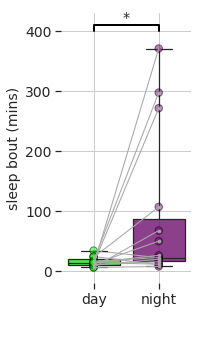

In [53]:
f, (ax1) = plt.subplots(ncols=1, sharex=True,figsize=(3, 5))

ax2 = sns.pointplot(x="zeit",y="mins",hue='flyname',data=plot_df,ax=ax1, dodge=0.0,
                    palette=['darkgray'])

g1 = sns.boxplot(x="zeit",y="mins",data = plot_df, whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            linewidth = 1.25, palette = typepal)
sns.stripplot(x="zeit",y="mins",data = plot_df, jitter=False, linewidth=1, ax=ax1,
              edgecolor ="black",palette=typepal, marker='o', s= 7.5, alpha = 0.5)


string_val = '*'

statannotation(ax = ax1, x1 = 0, x2 = 1, y = 400, text = string_val, h = 10)


ax1.legend_.remove()
b = list(ax1.get_children())

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

g1.set(xticklabels=['day', 'night'])

ax1.set_ylabel('sleep bout (mins)', fontsize=label_fontsize-2)
ax1.set_xlabel('\n', fontsize=label_fontsize-2)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

plt.tight_layout()
plt.box(False)
plt.grid(True)


In [54]:
inputfolderpath = basefolder + "data/beh_data/movement/8hrs_epoched/"

(array([738791.33333333, 738791.375     , 738791.41666667, 738791.45833333,
        738791.5       , 738791.54166667, 738791.58333333, 738791.625     ,
        738791.66666667, 738791.70833333, 738791.75      , 738791.79166667,
        738791.83333333, 738791.875     , 738791.91666667, 738791.95833333,
        738792.        , 738792.04166667, 738792.08333333, 738792.125     ,
        738792.16666667, 738792.20833333, 738792.25      , 738792.29166667,
        738792.33333333]),
 <a list of 25 Text xticklabel objects>)

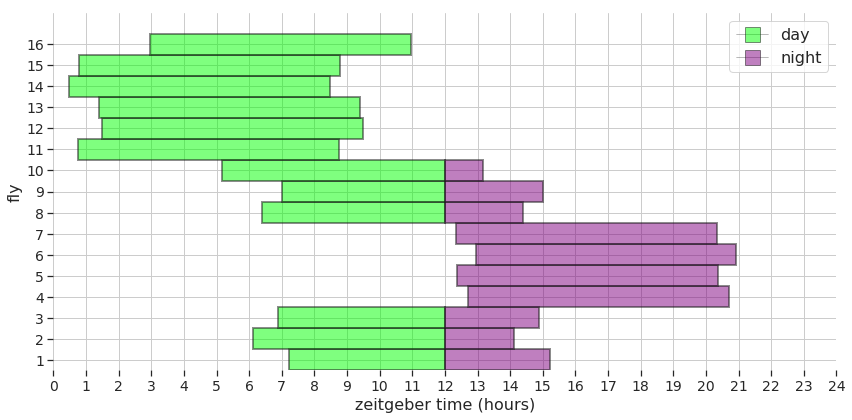

In [55]:
fig, ax = plt.subplots(figsize=(6*2, 3*2))

for f, basefilename in enumerate(basefiles):  # Loop across each fly
    inputfilepath = inputfolderpath + basefilename[3:] + "_merged_epochs.csv"
    
    df_timeepochs = pd.read_csv(inputfilepath, index_col = 0)
    df_timeepochs['Start_time'] = pd.to_datetime(df_timeepochs['Start_time'], format='%Y-%m-%d %H:%M:%S')
    df_timeepochs['End_time'] = pd.to_datetime(df_timeepochs['End_time'], format='%Y-%m-%d %H:%M:%S')
    df_timeepochs['Duration'] = df_timeepochs['End_time'] - df_timeepochs['Start_time']

    df_timeepochs['Start_time'] = df_timeepochs['Start_time'].dt.strftime('%H:%M:%S')
    df_timeepochs['End_time'] = df_timeepochs['End_time'].dt.strftime('%H:%M:%S')
    
#     print('\nindex', f)
#     print('name', basefilename[3:])
#     print('starttime', df_timeepochs.iloc[0]['Start_time'])
#     print('endtime', df_timeepochs.iloc[-1]['End_time'])
    
    if ((pd.to_datetime(df_timeepochs.iloc[0]['Start_time'], format='%H:%M:%S')) <\
        pd.to_datetime('20:00:00', format='%H:%M:%S')) and\
       ((pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S')) <\
        pd.to_datetime('20:00:00', format='%H:%M:%S')):
        #print('day-dayduration')
        day_duration = pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S') -\
                       pd.to_datetime(df_timeepochs.iloc[0]['Start_time'], format='%H:%M:%S')
        night_duration = pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S') -\
                         pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S')

    elif ((pd.to_datetime(df_timeepochs.iloc[0]['Start_time'], format='%H:%M:%S')) <\
        pd.to_datetime('20:00:00', format='%H:%M:%S')) and\
       ((pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S')) >\
        pd.to_datetime('20:00:00', format='%H:%M:%S')):
        #print('day-nightduration')
        day_duration = pd.to_datetime('20:00:00', format='%H:%M:%S') -\
                       pd.to_datetime(df_timeepochs.iloc[0]['Start_time'], format='%H:%M:%S')
        night_duration = pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S') -\
                         pd.to_datetime('20:00:00', format='%H:%M:%S')
    elif ((pd.to_datetime(df_timeepochs.iloc[0]['Start_time'], format='%H:%M:%S')) >\
        pd.to_datetime('20:00:00', format='%H:%M:%S')) and\
       ((pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S')) <\
        pd.to_datetime('08:00:00', format='%H:%M:%S')):
        #print('night-nightduration')
        night_duration = pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S') -\
                         pd.to_datetime(df_timeepochs.iloc[0]['Start_time'], format='%H:%M:%S') 
        night_duration = night_duration+ timedelta(days=1)
        day_duration =   pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S') -\
                         pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S')
    elif ((pd.to_datetime(df_timeepochs.iloc[0]['Start_time'], format='%H:%M:%S')) >\
        pd.to_datetime('20:00:00', format='%H:%M:%S')) and\
       ((pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S')) >\
        pd.to_datetime('08:00:00', format='%H:%M:%S')):
        #print('night-dayduration')
        night_duration = pd.to_datetime(df_timeepochs.iloc[0]['Start_time'], format='%H:%M:%S') -\
                         pd.to_datetime('08:00:00', format='%H:%M:%S') 
        day_duration =   pd.to_datetime(df_timeepochs.iloc[-1]['End_time'], format='%H:%M:%S') -\
                         pd.to_datetime('08:00:00', format='%H:%M:%S')
        
           
#     print('day_duration',day_duration)
#     print('day_duration -secs',day_duration.total_seconds()/60
#     print('night_duration',night_duration)
#     print('night_duration -secs',night_duration.total_seconds()/60)
    
#     agg_sleepperfly.loc[agg_sleepperfly['flyname'] == basefilename[3:],'day_duration'] =\
#                         day_duration.total_seconds()/60
#     agg_sleepperfly.loc[agg_sleepperfly['flyname'] == basefilename[3:],'night_duration'] =\
#                         night_duration.total_seconds()/60
    
    # df_timeepochs['Duration'] = df_timeepochs['Duration'].astype(str).map(lambda x: x[7:])
    
    # print(basefilename[3:] + ':' + df_timeepochs.iloc[0]['Start_time'])
    
    df_plotepochs = pd.DataFrame(columns = ['time', 'fly'])
    
    df_plotepochs['time'] = pd.date_range(start=df_timeepochs.iloc[0]['Start_time'], periods=9, freq='H')
    # df_plotepochs['fly'] = str(f+1).zfill(2) 
    df_plotepochs['fly'] = f'{f+1}' #f'{f+1:02}'
    
    df_plotepochs['type'] = 'night'
    
    df_plotepochs.loc[(df_plotepochs['time'].dt.hour>=8) & (df_plotepochs['time'].dt.hour<20),'type'] = 'day'
    

#     sns.scatterplot(x='time', y='fly', data=df_plotepochs, marker='o', ax = ax, sizes = 1, linewidth=1,
#                     edgecolor ="black")

#     sns.scatterplot(x='time', y='fly', data=df_plotepochs, marker='o', ax = ax, s = 250, linewidth=2,
#                         color = 'b', edgecolor ="black", palette=daynight_colordict, hue = 'type', alpha = 0.75,
#                         legend = False)
     
        
    sns.lineplot(x='time', y='fly', data=df_plotepochs, ax = ax, color ="black", alpha = 0)
    
    if any(df_plotepochs.type == 'day'):
        x_daystart = df_plotepochs.time[np.min(np.where(df_plotepochs.type == 'day'))]
        y_daystart = f-0.5
        day_len = day_duration
                  
        ax.add_patch(Rectangle(xy=(x_daystart, y_daystart),  # point of origin.
                               width=day_len, height=1, linewidth=2,
                               color='lime', ec = 'k', fill=True, alpha = 0.5))
    
    if any(df_plotepochs.type == 'night'):
        x_nightstart = df_plotepochs.time[np.max(np.where(df_plotepochs.type == 'night'))]-night_duration
        y_nightstart = f-0.5
        night_len = night_duration 
    
        ax.add_patch(Rectangle(xy=(x_nightstart, y_nightstart),  # point of origin.
                               width=night_len, height=1, linewidth=2,
                               color='purple', ec = 'k', fill=True, alpha = 0.5))
       
    
    
df_plotepochs = pd.DataFrame(columns = ['time', 'fly'])
df_plotepochs['time'] = pd.date_range(start='08:00:00', periods=25, freq='H')
df_plotepochs['fly'] = f'{f+1:02}'

# sns.lineplot(x='time', y='fly', data=df_plotepochs, ax = ax, color ="black", alpha = 0)
# sns.scatterplot(x='time', y='fly', data=df_plotepochs, marker='o', ax = ax, sizes = 1, linewidth=1,
#                     edgecolor ="black")    
    
    
ax.set_xlim(df_plotepochs.iloc[0]['time'], df_plotepochs.iloc[-1]['time'])
ax.set_ylim(-0.5, 16.5)

# ax.xaxis.set_major_formatter(DateFormatter('%H:%M')) 

hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)


ax.set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
                    '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25'))

sns.despine(left=True, bottom = True)
ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.ylabel('fly', fontsize=label_fontsize)
plt.xlabel('zeitgeber time (hours)', fontsize=label_fontsize)


custome_circles = [Line2D([0], [0], marker='s', color='k', label='Circle',
                        markerfacecolor='lime', markersize=15, alpha = 0.5),
                   Line2D([0], [0], marker='s', color='k', label='Circle',
                        markerfacecolor='purple', markersize=15, alpha = 0.5)]

ax.legend(custome_circles, ['day', 'night'], fontsize=label_fontsize, loc='upper right')

# plt.gca().invert_yaxis()

plt.tight_layout()
plt.box(False)
plt.grid(True)
plt.xticks(rotation=0) #90

In [56]:
df_plotepochs.head()

,time,fly
0,2023-09-28 08:00:00,16
1,2023-09-28 09:00:00,16
2,2023-09-28 10:00:00,16
3,2023-09-28 11:00:00,16
4,2023-09-28 12:00:00,16


In [57]:
basefiles[0][3:]

'27072018_SponSleep_LFP'

In [58]:
csvfolderpath = basefolder + "data/beh_data/movement/" + basefiles[0][3:] + "/"

In [59]:
movment_df_01 = pd.read_csv(csvfolderpath + basefiles[0][3:] + '_01_mov.csv')
movment_df_02 = pd.read_csv(csvfolderpath + basefiles[0][3:] + '_02_mov.csv')
movment_df_03 = pd.read_csv(csvfolderpath + basefiles[0][3:] + '_03_mov.csv')

In [60]:
movment_df = pd.concat([movment_df_01, movment_df_02, movment_df_03], ignore_index=True)

In [61]:
movment_df['disptime'] = movment_df['Year'].astype(str) + '-'+ movment_df['Month'].astype(str) + '-' +\
                         movment_df['Date'].astype(str) + ' '+ movment_df['Hour'].astype(str)  + ':' +\
                         movment_df['Mins'].astype(str) + ':'+ movment_df['Seconds'].astype(str)
movment_df['disptime'] = pd.to_datetime(movment_df['disptime'], format='%Y-%m-%d %H:%M:%S')

In [62]:
movment_df

,Year,Month,Date,Hour,Mins,Seconds,usec,nFrames,Movement,Area,disptime
0,2018,7,27,15,12,27,278000,1,Still,0.0,2018-07-27 15:12:27
1,2018,7,27,15,12,27,312000,2,Moved,5144.0,2018-07-27 15:12:27
2,2018,7,27,15,12,27,385000,3,Still,0.0,2018-07-27 15:12:27
3,2018,7,27,15,12,27,421000,4,Still,0.0,2018-07-27 15:12:27
4,2018,7,27,15,12,27,457000,5,Still,0.0,2018-07-27 15:12:27
...,...,...,...,...,...,...,...,...,...,...,...
297308,2018,7,27,18,12,27,227000,99159,Still,0.0,2018-07-27 18:12:27
297309,2018,7,27,18,12,27,263000,99160,Still,0.0,2018-07-27 18:12:27
297310,2018,7,27,18,12,27,299000,99161,Still,0.0,2018-07-27 18:12:27
297311,2018,7,27,18,12,27,335000,99162,Still,0.0,2018-07-27 18:12:27


In [63]:
plotbeh_df = movment_df.copy()

In [64]:
start_time = pd.to_datetime('2018-7-27 17:32:38', format='%Y-%m-%d %H:%M:%S')
stop_time =  pd.to_datetime('2018-7-27 18:02:00', format='%Y-%m-%d %H:%M:%S') # add 30 mins to the start_time

In [65]:
print('from : ',start_time)
print('to   : ',stop_time)

from :  2018-07-27 17:32:38
to   :  2018-07-27 18:02:00


In [66]:
selectindx = ((plotbeh_df.disptime >= start_time) &
             (plotbeh_df.disptime <= stop_time))

In [67]:
plotlabels_df = plotbeh_df.loc[selectindx]

plotlabels_df.loc[:,'Area'] = plotlabels_df.loc[selectindx, 'Area']

plotlabels_df.loc[:,'disptime2'] = plotlabels_df.loc[selectindx, 'disptime']

plotlabels_df.loc[:,'disptime'] = pd.to_datetime(plotlabels_df['disptime']).dt.strftime('%H:%M:%S')

plotlabels_df = plotlabels_df.reset_index()

plotlabels_df

,index,Year,Month,Date,Hour,Mins,Seconds,usec,nFrames,Movement,Area,disptime,disptime2
0,231485,2018,7,27,17,32,38,2000,33336,Moved,134.0,17:32:38,2018-07-27 17:32:38
1,231486,2018,7,27,17,32,38,38000,33337,Moved,86.0,17:32:38,2018-07-27 17:32:38
2,231487,2018,7,27,17,32,38,74000,33338,Moved,94.0,17:32:38,2018-07-27 17:32:38
3,231488,2018,7,27,17,32,38,111000,33339,Moved,165.5,17:32:38,2018-07-27 17:32:38
4,231489,2018,7,27,17,32,38,147000,33340,Still,0.0,17:32:38,2018-07-27 17:32:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48568,280053,2018,7,27,18,2,0,842000,81904,Still,0.0,18:02:00,2018-07-27 18:02:00
48569,280054,2018,7,27,18,2,0,878000,81905,Still,0.0,18:02:00,2018-07-27 18:02:00
48570,280055,2018,7,27,18,2,0,915000,81906,Still,0.0,18:02:00,2018-07-27 18:02:00
48571,280056,2018,7,27,18,2,0,951000,81907,Still,0.0,18:02:00,2018-07-27 18:02:00


In [68]:
import matplotlib.patches as patches

In [69]:
awakestart_01 = pd.to_datetime('2018-7-27 17:32:38', format='%Y-%m-%d %H:%M:%S')
awakeend_01 =   pd.to_datetime('2018-7-27 17:38:12', format='%Y-%m-%d %H:%M:%S')
awakeselectindx_01 = np.where((plotlabels_df.disptime2 >= awakestart_01) &
                              (plotlabels_df.disptime2 <= awakeend_01))

In [70]:
presleepstart_01 = pd.to_datetime('2018-7-27 17:38:13', format='%Y-%m-%d %H:%M:%S')
presleepend_01 =   pd.to_datetime('2018-7-27 17:40:13', format='%Y-%m-%d %H:%M:%S')
presleepselectindx_01 = np.where((plotlabels_df.disptime2 >= presleepstart_01) &
                                 (plotlabels_df.disptime2 <= presleepend_01))

In [71]:
sleepstart_01 = pd.to_datetime('2018-7-27 17:40:13', format='%Y-%m-%d %H:%M:%S')
sleepend_01 =   pd.to_datetime('2018-7-27 17:46:04', format='%Y-%m-%d %H:%M:%S')
sleepselectindx_01 = np.where((plotlabels_df.disptime2 >= sleepstart_01) &
                              (plotlabels_df.disptime2 <= sleepend_01))

In [72]:
awakestart_02 = pd.to_datetime('2018-7-27 17:46:05', format='%Y-%m-%d %H:%M:%S')
awakeend_02 =   pd.to_datetime('2018-7-27 18:02:24', format='%Y-%m-%d %H:%M:%S')
awakeselectindx_02 = np.where((plotlabels_df.disptime2 >= awakestart_02) &
                              (plotlabels_df.disptime2 <= awakeend_02))

In [73]:
# presleepstart_02 = pd.to_datetime('2018-7-27 22:10:29', format='%Y-%m-%d %H:%M:%S')
# presleepend_02 =   pd.to_datetime('2018-7-27 22:12:30', format='%Y-%m-%d %H:%M:%S')
# presleepselectindx_02 = np.where((plotlabels_df.disptime2 >= presleepstart_02) &
#                                  (plotlabels_df.disptime2 <= presleepend_02))

In [74]:
# sleepstart_02 = pd.to_datetime('2018-7-27 22:12:30', format='%Y-%m-%d %H:%M:%S')
# sleepend_02 =   pd.to_datetime('2018-7-27 22:17:53', format='%Y-%m-%d %H:%M:%S')
# sleepselectindx_02 = np.where((plotlabels_df.disptime2 >= sleepstart_02) &
#                               (plotlabels_df.disptime2 <= sleepend_02))

In [75]:
plotlabels_df.head()

,index,Year,Month,Date,Hour,Mins,Seconds,usec,nFrames,Movement,Area,disptime,disptime2
0,231485,2018,7,27,17,32,38,2000,33336,Moved,134.0,17:32:38,2018-07-27 17:32:38
1,231486,2018,7,27,17,32,38,38000,33337,Moved,86.0,17:32:38,2018-07-27 17:32:38
2,231487,2018,7,27,17,32,38,74000,33338,Moved,94.0,17:32:38,2018-07-27 17:32:38
3,231488,2018,7,27,17,32,38,111000,33339,Moved,165.5,17:32:38,2018-07-27 17:32:38
4,231489,2018,7,27,17,32,38,147000,33340,Still,0.0,17:32:38,2018-07-27 17:32:38


In [76]:
def convert2secs(x):
    x = x.split(":")
    if len(x) == 2:
        return int(x[0]) * 60 + int(x[1])
    return int(x[0]) * 3600 + int(x[1]) * 60 + int(x[2])

In [77]:
plotlabels_df["disptime_mins"] = plotlabels_df["disptime"].apply(convert2secs)

In [78]:
plotlabels_df["disptime_mins"] = plotlabels_df["disptime_mins"]/60

In [79]:
plotlabels_df["disptime_mins"] = plotlabels_df["disptime_mins"] - plotlabels_df["disptime_mins"][0]

In [80]:
plotlabels_df.disptime_mins = plotlabels_df.disptime_mins.round(0)

In [81]:
plotlabels_df.head()

,index,Year,Month,Date,Hour,Mins,Seconds,usec,nFrames,Movement,Area,disptime,disptime2,disptime_mins
0,231485,2018,7,27,17,32,38,2000,33336,Moved,134.0,17:32:38,2018-07-27 17:32:38,0.0
1,231486,2018,7,27,17,32,38,38000,33337,Moved,86.0,17:32:38,2018-07-27 17:32:38,0.0
2,231487,2018,7,27,17,32,38,74000,33338,Moved,94.0,17:32:38,2018-07-27 17:32:38,0.0
3,231488,2018,7,27,17,32,38,111000,33339,Moved,165.5,17:32:38,2018-07-27 17:32:38,0.0
4,231489,2018,7,27,17,32,38,147000,33340,Still,0.0,17:32:38,2018-07-27 17:32:38,0.0


In [82]:
plotlabels_df.tail()

,index,Year,Month,Date,Hour,Mins,Seconds,usec,nFrames,Movement,Area,disptime,disptime2,disptime_mins
48568,280053,2018,7,27,18,2,0,842000,81904,Still,0.0,18:02:00,2018-07-27 18:02:00,29.0
48569,280054,2018,7,27,18,2,0,878000,81905,Still,0.0,18:02:00,2018-07-27 18:02:00,29.0
48570,280055,2018,7,27,18,2,0,915000,81906,Still,0.0,18:02:00,2018-07-27 18:02:00,29.0
48571,280056,2018,7,27,18,2,0,951000,81907,Still,0.0,18:02:00,2018-07-27 18:02:00,29.0
48572,280057,2018,7,27,18,2,0,987000,81908,Still,0.0,18:02:00,2018-07-27 18:02:00,29.0


/home/srj34/deeplabcut-env/lib/python3.6/site-packages/pandas/core/indexes/range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 25000)

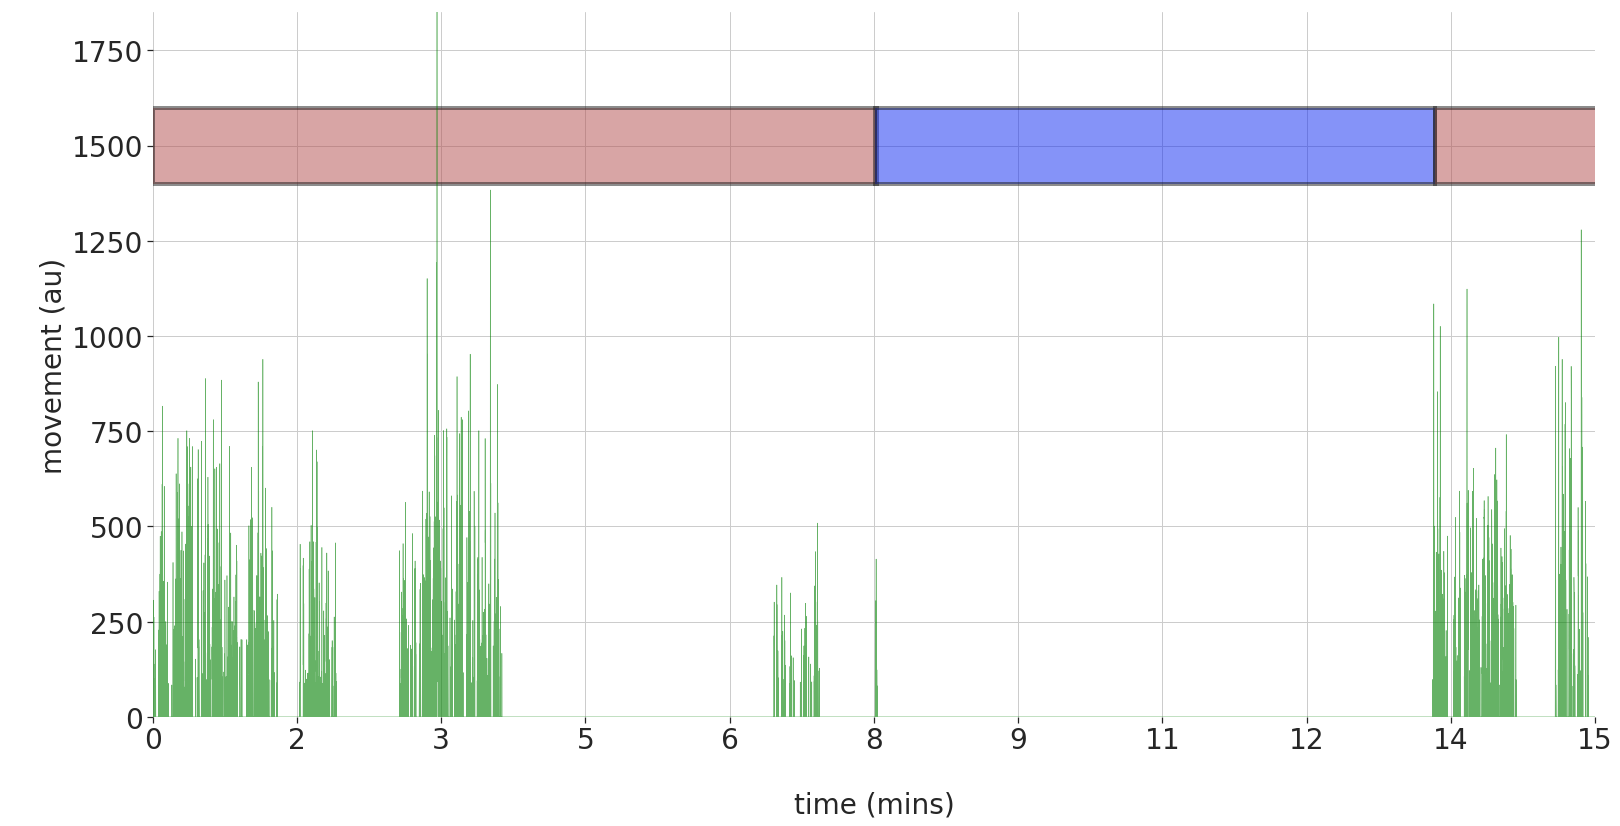

In [83]:
fig, ax = plt.subplots(figsize=(21, 7*1.5))

ax.plot(plotlabels_df.index,plotlabels_df['Area'],color='green', alpha = 0.6)
plt.xticks(plotlabels_df.index[0::2500],np.asarray(plotlabels_df["disptime_mins"].values[0::2500], dtype = 'int'))
plt.setp(ax.get_xticklabels(), rotation=0)

ax.margins(x=0)

sns.despine(left=True, bottom = True)

ax.add_patch(patches.Rectangle(xy=(np.min(awakeselectindx_01), 1400),  # point of origin.
                               width=len(awakeselectindx_01[0])+ len(presleepselectindx_01[0]), 
                               height=200, linewidth=4,
                              color='#b34d4d', ec = 'k', fill=True, alpha = 0.5))

# ax.add_patch(patches.Rectangle(xy=(np.min(presleepselectindx_01), 1400),  # point of origin.
#                                width=len(presleepselectindx_01[0]), height=200, linewidth=4,
#                               color='#f2ad0d', ec = 'k', fill=True, alpha = 0.5))


ax.add_patch(patches.Rectangle(xy=(np.min(sleepselectindx_01), 1400),  # point of origin.
                               width=len(sleepselectindx_01[0]), height=200, linewidth=4,
                              color='#0d28f2', ec = 'k', fill=True, alpha = 0.5))

ax.add_patch(patches.Rectangle(xy=(np.min(awakeselectindx_02), 1400),  # point of origin.
                               width=len(awakeselectindx_02[0]), height=200, linewidth=4,
                              color='#b34d4d', ec = 'k', fill=True, alpha = 0.5))

# ax.add_patch(patches.Rectangle(xy=(np.min(presleepselectindx_02), 1400),  # point of origin.
#                                width=len(presleepselectindx_02[0]), height=200, linewidth=4,
#                               color='#f2ad0d', ec = 'k', fill=True, alpha = 0.5))


# ax.add_patch(patches.Rectangle(xy=(np.min(sleepselectindx_02), 1400),  # point of origin.
#                                width=len(sleepselectindx_02[0]), height=200, linewidth=4,
#                               color='#0d28f2', ec = 'k', fill=True, alpha = 0.5))

ax.set_ylim([0, 1850])

plt.tight_layout()
plt.box(False)
plt.grid(True)

ax.set_ylabel('\nmovement (au)', fontsize=label_fontsize+12)
ax.set_xlabel('\ntime (mins)', fontsize=label_fontsize+12)
ax.tick_params(axis='both', which='major', labelsize=label_fontsize+12)

ax.set_xlim([0, 25000])

In [84]:
def activityperrechour(movfolderpath):
    
    
    df_mov = pd.read_csv(movfolderpath, index_col = 0)
    df_mov['date_time'] = pd.to_datetime(df_mov['disptime'], format='%Y-%m-%d %H:%M:%S')
    df_mov.drop('disptime', inplace = True, axis = 1)
    df_mov['hour_min'] = df_mov['date_time'].dt.hour
    df_mov['hour_min'] = df_mov['hour_min'] + (df_mov['date_time'].dt.minute)/100


    rollover = df_mov['date_time'].dt.hour < df_mov['date_time'].iloc[0].hour
    if (any(rollover)):
        print('\nrollover occured')
        
    df_mov['hours'] = df_mov['date_time'].dt.hour
    df_mov['hours'][rollover] = df_mov['hours'][rollover] + 24
    df_mov['seconds'] = df_mov['hours']*3600 + (df_mov['date_time'].dt.minute)*60
    df_mov['seconds'] = df_mov['seconds'] - np.min(df_mov['seconds'])

    df_mov['normhours'] = df_mov['seconds']/3600


    df_agg = df_mov.pivot_table(index = ['normhours'], values = ['Moved', 'Still'], aggfunc = 'sum')
    df_agg['prop'] = 1000*(df_agg['Moved']/(df_agg['Moved']+df_agg['Still']))
    df_agg['prop_zscore'] = (df_agg['prop'] - df_agg['prop'].mean())/df_agg['prop'].std(ddof=0)

    df_agg = df_agg.reset_index()
    
    max_time = int(df_agg['normhours'].max())
    intervals = [i for i in range(0, max_time + 1, 1)]
    
    df_agg['time_interval'] = pd.cut(df_agg['normhours'], intervals, include_lowest=True)


    # group the dataframe by time intervals and calculate the mean
    df_average = df_agg.groupby(['time_interval'])['prop_zscore'].mean()

    df_average = df_average.reset_index()

    # Create a new column with max value of time interval
    df_average['time_interval2'] = df_average['time_interval'].apply(lambda x: x.right - 1.0)
    
    
    return df_agg, df_average

In [85]:
df_recavgall = pd.DataFrame(columns = ['Moved', 'Still', 'prop', 'prop_zscore'])
df_recavgperflyall = pd.DataFrame(columns = ['flyname','time_interval2', 'prop_zscore'])
for f, basefilename in enumerate(basefiles):  # Loop across each fly
    movfolderpath = basefolder + "data/beh_data/movement/circrhythm/" +\
                    basefilename[3:] + "_circrhythm.csv"
    print(basefilename[3:])
    df_aggtemp, df_avgtemp =  activityperrechour(movfolderpath)
    df_avgtemp['flyname'] = basefilename[3:]
    
    df_avgperfly = df_avgtemp[['time_interval2','prop_zscore']]
    df_avgperfly['flyname'] = df_avgtemp['flyname'][0]
    
    
    df_recavgperflyall = df_recavgperflyall.append(df_avgperfly)
    
    df_recavgall = df_recavgall.append(df_avgtemp)

27072018_SponSleep_LFP

rollover occured
14092018_SponSleep_LFP
17092018_SponSleep_LFP
30102018_SponSleep_LFP

rollover occured
01112018_SponSleep_LFP

rollover occured
03112018_SponSleep_LFP

rollover occured
13112018_SponSleep_LFP

rollover occured
28112018_SponSleep_LFP
11122018_SponSleep_LFP

rollover occured
13122018_SponSleep_LFP
18122018_SponSleep_LFP
10012019_SponSleep_LFP
17012019_SponSleep_LFP
22012019_SponSleep_LFP
20022019_SponSleep_LFP
13032019_SponSleep_LFP


In [86]:
df_recavgperflyall = df_recavgperflyall[df_recavgperflyall['time_interval2']<=7]

In [87]:
df_recavgperflyall['time_interval2'] = df_recavgperflyall['time_interval2'].astype('int')
df_recavgperflyall['time_interval2'] = df_recavgperflyall['time_interval2'] + 1

In [88]:
# Convert eventtype to string and format as '01', '02', etc
df_recavgperflyall['rechours'] = df_recavgperflyall['time_interval2'].astype(str).str.zfill(1)

In [89]:
df_recavgperflyall = df_recavgperflyall.drop('time_interval2', axis=1)

In [90]:
df_recavgperflyall

,flyname,prop_zscore,rechours
0,27072018_SponSleep_LFP,-0.095977,1
1,27072018_SponSleep_LFP,-0.385757,2
2,27072018_SponSleep_LFP,-0.284828,3
3,27072018_SponSleep_LFP,-0.435822,4
4,27072018_SponSleep_LFP,-0.017530,5
...,...,...,...
3,13032019_SponSleep_LFP,0.426267,4
4,13032019_SponSleep_LFP,-0.426671,5
5,13032019_SponSleep_LFP,-0.489652,6
6,13032019_SponSleep_LFP,-0.599756,7


In [91]:
%R -i df_recavgperflyall

In [92]:
%%R
head(df_recavgperflyall)

                 flyname prop_zscore rechours
1 27072018_SponSleep_LFP -0.09597748        1
2 27072018_SponSleep_LFP -0.38575679        2
3 27072018_SponSleep_LFP -0.28482800        3
4 27072018_SponSleep_LFP -0.43582183        4
5 27072018_SponSleep_LFP -0.01752974        5
6 27072018_SponSleep_LFP -0.20426782        6


In [93]:
%%R
model.null = lmer(prop_zscore ~ 1 + (1|flyname), data=df_recavgperflyall,
                  REML=FALSE)

model.rectime = lmer(prop_zscore ~ rechours + (1|flyname), data=df_recavgperflyall,
                  REML=FALSE)

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



In [94]:
%%R
#compare the null model, with the rectime model..
print(anova(model.null,model.rectime))

Data: df_recavgperflyall
Models:
model.null: prop_zscore ~ 1 + (1 | flyname)
model.rectime: prop_zscore ~ rechours + (1 | flyname)
              Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)   
model.null     3 159.05 167.61 -76.525   153.05                            
model.rectime 10 149.77 178.29 -64.886   129.77 23.278      7   0.001524 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [95]:
%%R
#the above analysis show that the rectime model is the most likely model..
#let's analyse the same..
print(anova(model.rectime))

Type III Analysis of Variance Table with Satterthwaite's method
         Sum Sq Mean Sq NumDF DenDF F value   Pr(>F)   
rechours 4.1198 0.58854     7   128  3.6471 0.001274 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [96]:
%%R
library("MuMIn")
r.squaredGLMM(model.rectime)

           R2m       R2c
[1,] 0.1673742 0.1673742


In [97]:
%%R
#the above table shows that there is a main effect of recording time; let's find out more..

NULL


In [98]:
%%R
library("multcomp")
# Step 5: Post Hoc comparisions 

model = lmer(prop_zscore ~ rechours + (1|flyname), data=df_recavgperflyall,
             REML=FALSE)

print(summary(glht(model, mcp(rechours="Tukey"))))

R[write to console]: boundary (singular) fit: see ?isSingular




	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = prop_zscore ~ rechours + (1 | flyname), data = df_recavgperflyall, 
    REML = FALSE)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)    
2 - 1 == 0 -0.44638    0.14203  -3.143  0.03565 *  
3 - 1 == 0 -0.52729    0.14203  -3.713  0.00499 ** 
4 - 1 == 0 -0.37300    0.14203  -2.626  0.14677    
5 - 1 == 0 -0.43501    0.14203  -3.063  0.04529 *  
6 - 1 == 0 -0.46219    0.14203  -3.254  0.02528 *  
7 - 1 == 0 -0.55771    0.14203  -3.927  0.00220 ** 
8 - 1 == 0 -0.63551    0.14203  -4.475  < 0.001 ***
3 - 2 == 0 -0.08091    0.14203  -0.570  0.99921    
4 - 2 == 0  0.07338    0.14203   0.517  0.99958    
5 - 2 == 0  0.01137    0.14203   0.080  1.00000    
6 - 2 == 0 -0.01581    0.14203  -0.111  1.00000    
7 - 2 == 0 -0.11133    0.14203  -0.784  0.99397    
8 - 2 == 0 -0.18913    0.14203  -1.332  0.88688    
4 - 3 == 0  0.15428    0.14203   1.086  0.95

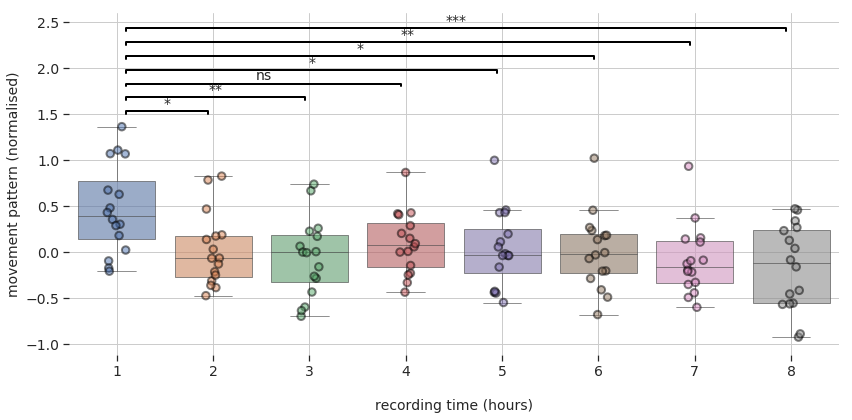

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax = sns.stripplot(x="rechours", y="prop_zscore", data=df_recavgperflyall, jitter=True, 
                   edgecolor ="black",marker='o', s= 7.5, alpha = 0.5,
                   linewidth=2)
g1 = sns.boxplot(x = "rechours", y="prop_zscore", data = df_recavgperflyall, 
                 showfliers = False)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6)) 
    
    
sns.despine(left=True, bottom = True)


string_val1 = '*'
string_val2 = '**'
string_val3 = '***'
string_val4 = 'ns'
statannotation(ax = ax, x1 = 0.095, x2 = 0.95, y = 1.5, h = 0.125/4, text = string_val1)
statannotation(ax = ax, x1 = 0.095, x2 = 0.95+1, y = 1.5+0.15, h = 0.125/4, text = string_val2)

statannotation(ax = ax, x1 = 0.095, x2 = 0.95+1*2, y = 1.5+0.15*2, h = 0.125/4, text = string_val4)


statannotation(ax = ax, x1 = 0.095, x2 = 0.95+1*3, y = 1.5+0.15*3, h = 0.125/4, text = string_val1)
statannotation(ax = ax, x1 = 0.095, x2 = 0.95+1*4, y = 1.5+0.15*4, h = 0.125/4, text = string_val1)
statannotation(ax = ax, x1 = 0.095, x2 = 0.95+1*5, y = 1.5+0.15*5, h = 0.125/4, text = string_val2)
statannotation(ax = ax, x1 = 0.095, x2 = 0.95+1*6, y = 1.5+0.15*6, h = 0.125/4, text = string_val3)


ax.set_ylabel('movement pattern (normalised)', fontsize=label_fontsize-2)
ax.set_xlabel('\nrecording time (hours)', fontsize=label_fontsize-2)
ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

plt.tight_layout()
plt.box(False)
plt.grid(True)

In [100]:
def activitypercrephour(movfolderpath):
    
    df_mov = pd.read_csv(movfolderpath, index_col = 0)
    
    df_activity = pd.read_csv(movfolderpath, index_col = 0)
    df_activity['date_time'] = pd.to_datetime(df_activity['disptime'], format='%Y-%m-%d %H:%M:%S')
    df_activity.drop('disptime', inplace = True, axis = 1)

    df_activity['creptype'] = None

    #dawn timings..
    df_activity.loc[(df_activity['date_time'].dt.hour>=5) & (df_activity['date_time'].dt.hour<7),\
                    'creptype'] = 'precrep'
    df_activity.loc[(df_activity['date_time'].dt.hour>=7) & (df_activity['date_time'].dt.hour<9),\
                    'creptype'] = 'crep'
    df_activity.loc[(df_activity['date_time'].dt.hour>=9) & (df_activity['date_time'].dt.hour<11),\
                    'creptype'] = 'postcrep'


    #dusk timings..
    df_activity.loc[(df_activity['date_time'].dt.hour>=17) & (df_activity['date_time'].dt.hour<19),\
                    'creptype'] = 'precrep'
    df_activity.loc[(df_activity['date_time'].dt.hour>=19) & (df_activity['date_time'].dt.hour<21),\
                    'creptype'] = 'crep'
    df_activity.loc[(df_activity['date_time'].dt.hour>=21) & (df_activity['date_time'].dt.hour<23),\
                    'creptype'] = 'postcrep'

    df_activityagg = df_activity[df_activity['creptype'].isin(['crep', 'precrep', 'postcrep'])]
    df_activityagg = df_activityagg[['prop','creptype']]
    
    df_activityagg['prop_zscore'] = (df_activityagg['prop'] - df_activityagg['prop'].mean())/df_activityagg['prop'].std(ddof=0)
    
    return df_activityagg

In [101]:
df_activityaggperflyall = pd.DataFrame(columns = ['flyname','creptype', 'prop_zscore'])
for f, basefilename in enumerate(basefiles):  # Loop across each fly
    movfolderpath = basefolder + "data/beh_data/movement/circrhythm/" +\
                    basefilename[3:] + "_circrhythm.csv"
    print(basefilename[3:])
    df_activityaggtemp =  activitypercrephour(movfolderpath)
    df_activityaggtemp['flyname'] = basefilename[3:]
    
    df_activityaggtemp = df_activityaggtemp[['flyname', 'creptype', 'prop_zscore']]
    
    
    df_activityaggperflyall = df_activityaggperflyall.append(df_activityaggtemp)

27072018_SponSleep_LFP
14092018_SponSleep_LFP
17092018_SponSleep_LFP
30102018_SponSleep_LFP
01112018_SponSleep_LFP
03112018_SponSleep_LFP
13112018_SponSleep_LFP
28112018_SponSleep_LFP
11122018_SponSleep_LFP
13122018_SponSleep_LFP
18122018_SponSleep_LFP
10012019_SponSleep_LFP
17012019_SponSleep_LFP
22012019_SponSleep_LFP
20022019_SponSleep_LFP
13032019_SponSleep_LFP


In [102]:
df_activityaggperflyall

,flyname,creptype,prop_zscore
109,27072018_SponSleep_LFP,precrep,-0.733863
110,27072018_SponSleep_LFP,precrep,1.176773
111,27072018_SponSleep_LFP,precrep,-0.727301
112,27072018_SponSleep_LFP,precrep,-0.195145
113,27072018_SponSleep_LFP,precrep,1.126306
...,...,...,...
537,13032019_SponSleep_LFP,crep,0.108081
538,13032019_SponSleep_LFP,crep,0.768248
539,13032019_SponSleep_LFP,crep,0.575714
540,13032019_SponSleep_LFP,crep,0.586918


In [103]:
missing_df = []
# iterate over all flyname and creptypes to check for missing data in particular times
for flyname in df_activityaggperflyall['flyname'].unique():
    for creptype in df_activityaggperflyall['creptype'].unique():
        # check if the current flyname/creptype combination is already present
        if not ((df_activityaggperflyall['flyname'] == flyname) & (df_activityaggperflyall['creptype'] == creptype)).any():
            # if not, add a row with the missing creptype and NaN for mins
            new_row = {'flyname': flyname, 'creptype': creptype, 'prop_zscore': np.nan}
            missing_df.append(new_row)

In [104]:
missing_df = pd.DataFrame(missing_df)
missing_df

,flyname,creptype,prop_zscore
0,18122018_SponSleep_LFP,precrep,NaN
1,10012019_SponSleep_LFP,crep,NaN
2,17012019_SponSleep_LFP,crep,NaN


In [105]:
df_activityaggperflyall = pd.concat([df_activityaggperflyall,missing_df])

In [106]:
df_activityaggperflyall['creptype'].unique()

array(['precrep', 'crep', 'postcrep'], dtype=object)

In [107]:
len(df_activityaggperflyall['flyname'].unique())

16

In [108]:
%R -i df_activityaggperflyall

In [109]:
%%R
head(df_activityaggperflyall)

                 flyname creptype prop_zscore
1 27072018_SponSleep_LFP  precrep  -0.7338633
2 27072018_SponSleep_LFP  precrep   1.1767730
3 27072018_SponSleep_LFP  precrep  -0.7273015
4 27072018_SponSleep_LFP  precrep  -0.1951446
5 27072018_SponSleep_LFP  precrep   1.1263059
6 27072018_SponSleep_LFP  precrep  -0.2345630


In [110]:
%%R
unique(df_activityaggperflyall$creptype)

[1] "precrep"  "crep"     "postcrep"


In [111]:
%%R
packageVersion("lme4")

[1] ‘1.1.21’


In [112]:
%%R
# Multilevel model with missing values ~ Hierarchical model
# First compare and choose the best model..

library(lmerTest)

In [113]:
%%R
head(df_activityaggperflyall)

                 flyname creptype prop_zscore
1 27072018_SponSleep_LFP  precrep  -0.7338633
2 27072018_SponSleep_LFP  precrep   1.1767730
3 27072018_SponSleep_LFP  precrep  -0.7273015
4 27072018_SponSleep_LFP  precrep  -0.1951446
5 27072018_SponSleep_LFP  precrep   1.1263059
6 27072018_SponSleep_LFP  precrep  -0.2345630


In [114]:
%%R
model.null = lmer(prop_zscore ~ 1 + (1|flyname), data=df_activityaggperflyall,
                  REML=FALSE)

model.creptype = lmer(prop_zscore ~ creptype + (1|flyname), data=df_activityaggperflyall,
                  REML=FALSE)

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



In [115]:
%%R
#compare the null model, with the creptype model..
print(anova(model.null,model.creptype))

Data: df_activityaggperflyall
Models:
model.null: prop_zscore ~ 1 + (1 | flyname)
model.creptype: prop_zscore ~ creptype + (1 | flyname)
               Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null      3 11301 11320 -5647.4    11295                             
model.creptype  5 11224 11255 -5606.8    11214 81.157      2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [116]:
%%R
#the above analysis show that the creptype model is the most likely model..
#let's analyse the same..
print(anova(model.creptype))

Type III Analysis of Variance Table with Satterthwaite's method
         Sum Sq Mean Sq NumDF DenDF F value    Pr(>F)    
creptype 80.335  40.168     2  3980  40.995 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [117]:
%%R
library("MuMIn")
r.squaredGLMM(model.creptype)

            R2m        R2c
[1,] 0.02018971 0.02018971


In [118]:
%%R
#the above table shows that there is a main effect of creptype(precrep,crep,postcrep); let's find out more..

NULL


In [119]:
%%R
library("multcomp")
# Step 5: Post Hoc comparisions 

model = lmer(prop_zscore ~ creptype + (1|flyname), data=df_activityaggperflyall,
             REML=FALSE)

print(summary(glht(model, mcp(creptype="Tukey"))))

R[write to console]: boundary (singular) fit: see ?isSingular




	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = prop_zscore ~ creptype + (1 | flyname), data = df_activityaggperflyall, 
    REML = FALSE)

Linear Hypotheses:
                        Estimate Std. Error z value Pr(>|z|)    
postcrep - crep == 0    -0.30441    0.03924  -7.757   <1e-04 ***
precrep - crep == 0     -0.35198    0.04211  -8.358   <1e-04 ***
precrep - postcrep == 0 -0.04756    0.03682  -1.292    0.399    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



In [120]:
df_activityaggperflyall

,flyname,creptype,prop_zscore
109,27072018_SponSleep_LFP,precrep,-0.733863
110,27072018_SponSleep_LFP,precrep,1.176773
111,27072018_SponSleep_LFP,precrep,-0.727301
112,27072018_SponSleep_LFP,precrep,-0.195145
113,27072018_SponSleep_LFP,precrep,1.126306
...,...,...,...
540,13032019_SponSleep_LFP,crep,0.586918
541,13032019_SponSleep_LFP,crep,-0.693971
0,18122018_SponSleep_LFP,precrep,NaN
1,10012019_SponSleep_LFP,crep,NaN


In [121]:
df_plotactivityaggperflyall = df_activityaggperflyall[["flyname","creptype","prop_zscore"]].groupby(['flyname',\
                                                             'creptype']).agg(['mean']).reset_index()

In [122]:
df_plotactivityaggperflyall.columns = df_plotactivityaggperflyall.columns.map(''.join)

In [123]:
df_plotactivityaggperflyall = df_plotactivityaggperflyall.rename(columns={'prop_zscoremean': 'activity'})

In [124]:
#for displaying in pointplot..
removeptpltdatasets = df_activityaggperflyall['flyname'][df_activityaggperflyall['prop_zscore'].isna()]

In [125]:
typepal = {'crep':'r', 'precrep': 'b', 'postcrep': 'b'}

[Text(0, 0, 'pre\ncrepuscular'),
 Text(0, 0, 'crepuscular'),
 Text(0, 0, 'post\ncrepuscular')]

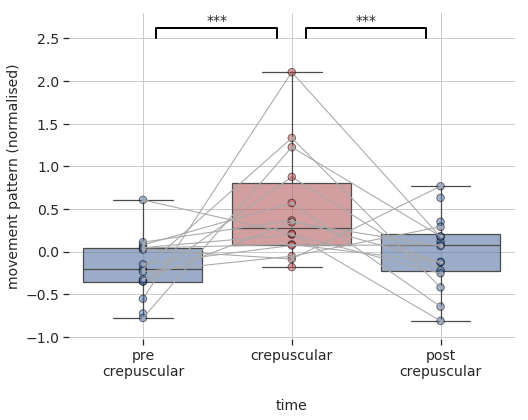

In [126]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

sns.pointplot(x="creptype",y="activity", hue='flyname',
              data=df_plotactivityaggperflyall[~df_plotactivityaggperflyall['flyname'].isin(removeptpltdatasets)],
              ax=ax1, dodge=0.0,
              order=['precrep','crep','postcrep'],
                    palette=['darkgray'])

sns.boxplot(x="creptype",y="activity",data = df_plotactivityaggperflyall, whis=np.inf, ax=ax1,
            showbox=True,dodge=False,meanline=True,showmeans=False, showfliers=True,showcaps=True, 
            order=['precrep','crep','postcrep'],
            linewidth = 1.25, palette = typepal)

sns.stripplot(x="creptype",y="activity",data = df_plotactivityaggperflyall, jitter=False, linewidth=1, ax=ax1,
              order=['precrep','crep','postcrep'], marker='o', s= 7.5, alpha = 0.5,
              edgecolor ="black",palette=typepal)

string_val3 = '***'
statannotation(ax = ax1, x1 = 0.09, x2 = 10*0.09, y = 2.5, h = 0.125, text = string_val3)
statannotation(ax = ax1, x1 = 0.9+2.20*0.09, x2 = 1.09 + 9*0.09, y = 2.5, h = 0.125, text = string_val3)




ax1.legend_.remove()
b = list(ax1.get_children())

for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
sns.despine(left=True, bottom = True)


ax1.set_ylabel('movement pattern (normalised)', fontsize=label_fontsize-2)
ax1.set_xlabel('\ntime', fontsize=label_fontsize-2)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

ax1.grid(True)
ax1.set_xticklabels(['pre\ncrepuscular', 'crepuscular', 'post\ncrepuscular'])